In [1]:
import torch
import sys
import os
import os.path as osp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
import matplotlib as mpl
from sklearn.metrics import precision_recall_curve
from sklearn import metrics

In [2]:
root_dir = "/home/users/richras/Ge2Net_Repo"
os.chdir(root_dir)

In [3]:
!./ini.sh

set environment variables
All done


In [4]:
os.environ['USER_PATH']='/home/users/richras/Ge2Net_Repo'
os.environ['USER_SCRATCH_PATH']="/scratch/users/richras"
os.environ['IN_PATH']='/scratch/groups/cdbustam/richras/data_in'
os.environ['OUT_PATH']='/scratch/groups/cdbustam/richras/data_out'
os.environ['LOG_PATH']='/scratch/groups/cdbustam/richras/logs/'

In [108]:
%load_ext autoreload
%autoreload 2
from src.utils.dataUtil import load_path, save_file, vcf2npy, get_recomb_rate, interpolate_genetic_pos, form_windows,\
getValueBySelection
from src.utils.modelUtil import Params, load_model
from src.utils.decorators import timer
from src.utils.labelUtil import repeat_pop_arr, getSuperpopBins
from src.models import AuxiliaryTask, LSTM, Attention, BasicBlock, Model_A, Model_B, Model_C, BOCD
from src.models.distributions import Multivariate_Gaussian
from src.main.evaluation import eval_cp_batch, reportChangePointMetrics, t_prMetrics, cpMethod, eval_cp_matrix
from src.main.settings_model import parse_args, MODEL_CLASS
import test

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Specify the dataset to be evaluated
# chm22 pca full dataset and model
labels_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_3_pca')
data_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_3_pca')
models_path=osp.join(os.environ['OUT_PATH'],'humans/training/Model_B_exp_id_6_data_id_3_pca/') 
dataset_type='valid'

In [7]:
# load the params file and run test.py

In [8]:
config={}
config['data.labels']=labels_path 
config['data.dir']=data_path 
config['models.dir']=models_path
config['data.dataset_type']=dataset_type
config['cuda']='cuda'
json_path = osp.join(config['models.dir'], 'params.json')
assert osp.isfile(json_path), "No json configuration file found at {}".format(json_path)
params = Params(json_path)
params.rtnOuts=True
params.mc_dropout=True
params.mc_samples=100
params.cp_tol=0
results, test_dataset=test.main(config, params)

 device used: cuda
Loading the datasets...
Finished 'transform_data' in 28.1629 secs
Finished '__init__' in 34.5348 secs
model ['Model_B.model_B'] : AuxiliaryTask.AuxNetwork
model ['Model_B.model_B'] : LSTM.BiRNN
model ['Model_B.model_B'] : BasicBlock.logits_Block
best val loss metrics : {'gcd': None, 'mse': 0.2178936406499827, 'smooth_l1': 0.10351521903088674, 'weighted_loss': 0.3591735236903656, 'loss_main': 0.3591735236903656, 'loss_aux': 0.8821184329220864}
at epoch : 87
train loss metrics: {'gcd': None, 'mse': 0.10320528280809713, 'smooth_l1': 0.04959562086833885, 'weighted_loss': 0.2486219141212711, 'loss_main': 0.2296785485357874, 'loss_aux': 0.9173492295086926}
best val cp metrics : {'loss_cp': 0.07215550060296119, 'Precision': 1.0, 'Recall': 0.4043835616438356, 'Accuracy': 0.9863497688086083, 'A_major': 1.0, 'BalancedAccuracy': 0.7021917808219178}
train cp metrics: {'loss_cp': 0.20510284079111923, 'Precision': 0.9839462324729361, 'Recall': 0.713593694662275, 'Accuracy': 0.9933

In [9]:
torch.cuda.is_available()

True

In [10]:
results.t_accr, results.t_cp_accr

({'gcd': None,
  'loss_aux': 0.9119396815986777,
  'loss_main': 0.3461540393673566,
  'mse': 0.18840505032328983,
  'smooth_l1': 0.09020874936023994,
  'weighted_loss': 0.3461540393673566},
 {'A_major': 0.9998428948598298,
  'Accuracy': 0.9939553174020138,
  'BalancedAccuracy': 0.7441329258297497,
  'Precision': 0.9674990215264188,
  'Recall': 0.4884229567996692,
  'loss_cp': 0.20465141559150965})

In [11]:
test_dataset.data['cps'].shape

torch.Size([3650, 317])

In [12]:
results.t_out.cp_logits.shape, results.t_out.coord_main.shape, results.t_out.y_var.shape

((3650, 317, 1), (3650, 317, 3), (3650, 317, 3))

In [13]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [94]:
@timer
def prMetricsByThresh(method_name, cp_pred_raw, cp_target, steps):
    num_samples = cp_target.shape[0]
    seqlen = cp_target.shape[1]
    min_prob = 0.0
    max_prob = 10.0
    increment = (max_prob - min_prob)/steps
    df=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
    for thresh in np.arange(min_prob, max_prob + increment, increment):
        prMetrics,_ = reportChangePointMetrics(method_name, cp_pred_raw, cp_target, seqlen, thresh)
        prMetrics['thresh']=thresh
        df=df.append(prMetrics, ignore_index=True)
    return df

In [68]:
df_nn=prMetricsByThresh(cpMethod.neural_network.name, torch.tensor(results.t_out.cp_logits).float(), \
                        test_dataset.data['cps'].unsqueeze(2).float(), 20)
df_nn

Finished 'prMetricsByThresh' in 18.9422 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh
0,0.007335,1.000000,0.033319,0.026874,0.513437,0.00
1,0.021447,0.952573,0.705880,0.704433,0.828503,0.05
2,0.021489,0.947606,0.707674,0.706301,0.826954,0.10
3,0.021433,0.943957,0.708310,0.706986,0.825472,0.15
4,0.021424,0.942471,0.708682,0.707380,0.824926,0.20
5,0.021382,0.940592,0.708924,0.707647,0.824120,0.25
6,0.021364,0.939705,0.709095,0.707833,0.823769,0.30
7,0.021358,0.939086,0.709223,0.707968,0.823527,0.35
8,0.021336,0.938091,0.709356,0.708113,0.823102,0.40
9,0.021366,0.937233,0.710164,0.708941,0.823087,0.45


In [16]:
precision, recall, thresholds = metrics.roc_curve(test_dataset.data['cps'].detach().cpu().numpy().flatten(),
                                    torch.sigmoid(torch.tensor(results.t_out.cp_logits.flatten()).float()))

In [17]:
precision, recall, thresholds

(array([0.        , 0.        , 0.        , ..., 0.99998695, 0.99999304,
        1.        ]),
 array([0.00000000e+00, 1.25675506e-04, 3.77026518e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 array([1.5073826 , 0.5073827 , 0.50719225, ..., 0.0112325 , 0.01123249,
        0.01123249], dtype=float32))

In [18]:
print(prMetricsByThresh(cpMethod.gradient.name, torch.tensor(results.t_out.coord_main).float(), \
                        test_dataset.data['cps'].unsqueeze(2).float(), 20))

Finished 'prMetricsByThresh' in 9.0287 secs
    Precision    Recall  Accuracy   A_major  BalancedAccuracy  thresh
0    0.007360  1.000000  0.036458  0.030035          0.515017    0.00
1    0.181647  0.868860  0.952505  0.953578          0.911219    0.05
2    0.406363  0.843936  0.978609  0.980243          0.912089    0.10
3    0.519962  0.825680  0.986490  0.988422          0.907051    0.15
4    0.616492  0.809002  0.990187  0.992341          0.900671    0.20
5    0.701802  0.796062  0.992365  0.994692          0.895377    0.25
6    0.753902  0.785613  0.993629  0.996103          0.890858    0.30
7    0.793192  0.775167  0.994400  0.997011          0.886089    0.35
8    0.822036  0.766072  0.994916  0.997653          0.881863    0.40
9    0.841695  0.754351  0.995256  0.998128          0.876239    0.45
10   0.862171  0.744114  0.995496  0.998488          0.871301    0.50
11   0.883946  0.735353  0.995694  0.998794          0.867074    0.55
12   0.900143  0.725445  0.995820  0.999049   

In [19]:
print(prMetricsByThresh(cpMethod.mc_dropout.name, torch.tensor(results.t_out.y_var).float(), \
                        test_dataset.data['cps'].unsqueeze(2).float(), 20))

Finished 'prMetricsByThresh' in 7.3621 secs
    Precision    Recall  Accuracy   A_major  BalancedAccuracy  thresh
0    0.007335  1.000000  0.033319  0.026874          0.513437    0.00
1    0.430133  0.756694  0.932110  0.934266          0.845480    0.05
2    0.522339  0.630189  0.959826  0.963675          0.796932    0.10
3    0.583650  0.541147  0.971425  0.976395          0.758771    0.15
4    0.641437  0.486312  0.978285  0.983974          0.735143    0.20
5    0.700557  0.452758  0.982394  0.988514          0.720636    0.25
6    0.748513  0.435593  0.985258  0.991625          0.713609    0.30
7    0.794554  0.425203  0.987269  0.993800          0.709501    0.35
8    0.840617  0.419616  0.988818  0.995443          0.707530    0.40
9    0.873519  0.414872  0.989944  0.996643          0.705757    0.45
10   0.898652  0.411545  0.990809  0.997563          0.704554    0.50
11   0.920543  0.409068  0.991451  0.998246          0.703657    0.55
12   0.943452  0.407240  0.991929  0.998756   

In [20]:
#chm22 genetic map and vcf (vcf is used to get the snp position)
config['data.genetic_map'] = osp.join(os.environ.get('IN_PATH'), 'humans/reference_files/allchrs.b38.gmap')
config['data.vcf_dir'] = osp.join(os.environ.get('IN_PATH'), 'humans/master_vcf_files/ref_final_beagle_phased_1kg_hgdp_sgdp_chr22.vcf.gz')

In [21]:
#get recomb_rate
genetic_map_path = config['data.genetic_map']
vcf_file_path = config['data.vcf_dir']
df_gm_chm22, df_vcf, df_snp_pos = get_recomb_rate(genetic_map_path, vcf_file_path, chm='chr22')
df_snp_pos = interpolate_genetic_pos(df_snp_pos, df_gm_chm22)
recomb_w = form_windows(df_snp_pos, params.chmlen, params.win_size)
recomb_rate = np.diff(recomb_w)

Finished 'get_recomb_rate' in 70.1698 secs
Finished 'interpolate_genetic_pos' in 0.0033 secs
Finished 'form_windows' in 0.0018 secs


In [22]:
recomb_rate.shape

(316,)

In [109]:
y_pred = results.t_out.coord_main
n_vec_dim=y_pred.shape[-1]
data_tensor = torch.tensor(y_pred).float()
pred_cps, predictive_ls, e_mean_ls = [], [] ,[]

batch_size_cpd = data_tensor.shape[0]
mu_prior = torch.mean(data_tensor, dim =1).float().reshape(batch_size_cpd, 1,n_vec_dim)
cov_prior = (torch.var(data_tensor, dim =1).float().unsqueeze(1) * \
             torch.eye(n_vec_dim)).reshape(batch_size_cpd,1,n_vec_dim,n_vec_dim)
cov_x = torch.eye(n_vec_dim).unsqueeze(0).repeat([batch_size_cpd,1,1]).reshape(batch_size_cpd,1,n_vec_dim,n_vec_dim)
print(data_tensor.shape, cov_prior.shape, mu_prior.shape, cov_x.shape)
likelihood_model = Multivariate_Gaussian(mu_prior, cov_prior, cov_x)
T = params.n_win
model_cpd = BOCD.BOCD(recomb_rate, T, likelihood_model, batch_size_cpd)

posterior, _, predictive, e_mean = model_cpd.run_recursive(data_tensor, 'cpu')
pred_cps.append(model_cpd.cp)
predictive_ls.append(predictive)
e_mean_ls.append(e_mean)

torch.Size([3650, 317, 3]) torch.Size([3650, 1, 3, 3]) torch.Size([3650, 1, 3]) torch.Size([3650, 1, 3, 3])
Finished 'run_recursive' in 208.5128 secs


In [110]:
bocp_rl = model_cpd.cp.detach().numpy()
bocp_rl_diff = bocp_rl[:,1:]-bocp_rl[:,:-1]
bocd_cp = np.zeros((batch_size_cpd, T))
bocd_cp_idx = np.nonzero((bocp_rl_diff<-4))
for i,j in zip(bocd_cp_idx[0], bocd_cp_idx[1]):
    if bocp_rl[i,j+1]<4:
        bocd_cp[i,j]=1

In [111]:
df_bocd=prMetricsByThresh(cpMethod.BOCD.name, model_cpd.cp, \
                        test_dataset.data['cps'].unsqueeze(2).float(), 20)
df_bocd

Finished 'prMetricsByThresh' in 13.3733 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh
0,1.000000,0.404384,0.993123,1.000000,0.702192,0.0
1,1.000000,0.404384,0.993123,1.000000,0.702192,0.5
2,1.000000,0.404384,0.993123,1.000000,0.702192,1.0
3,0.898862,0.655931,0.995381,0.999413,0.827672,1.5
4,0.898862,0.655337,0.995378,0.999413,0.827375,2.0
5,0.785622,0.745094,0.995397,0.998380,0.871737,2.5
6,0.784089,0.741601,0.995367,0.998388,0.869995,3.0
7,0.724825,0.757222,0.994842,0.997689,0.877456,3.5
8,0.724537,0.752698,0.994813,0.997712,0.875205,4.0
9,0.687652,0.758183,0.994378,0.997211,0.877697,4.5


In [112]:
bocp_rl_diff.shape

(3650, 317)

In [113]:
np.unique(np.nonzero(test_dataset.data['cps'])[:,0]).shape, np.unique(np.nonzero(bocd_cp)[0]).shape

((2174,), (2526,))

In [114]:
np.nonzero(test_dataset.data['cps'][1253,:]), np.nonzero(bocd_cp[1253,:])

(tensor([[199]]), (array([199]),))

In [115]:
eval_cp_matrix(np.nonzero(test_dataset.data['cps'][1253,:].detach().cpu()), np.nonzero(bocd_cp[1253,:])[0], seq_len=317)

(1, 0, 0, 316, array([[0.]]))

# Qualitative by looking at anecdotes/samples

In [116]:
[cp.name for cp in cpMethod]

['neural_network', 'gradient', 'mc_dropout', 'BOCD']

In [117]:
# index=2500
index = 1313
cp_target=test_dataset.data['cps']
seqlen=cp_target.shape[1]
cpThresh=[0.49, 0.2, 0.10, 3]
cp_pred_raw=[  torch.tensor(results.t_out.cp_logits).float(), torch.tensor(results.t_out.coord_main).float(), 
             torch.tensor(results.t_out.y_var).float(), model_cpd.cp]
pred_cps = {}
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    _, pred_cps[name]= reportChangePointMetrics(name, pred_raw, cp_target, seqlen, thresh)

true_cps=cp_target.detach().cpu().numpy()
pred_cps={k:v.detach().cpu().numpy() for k,v in pred_cps.items()}

In [118]:
def plot_changepoints(true_cps, pred_cps, y_pred, bocp_rl, y_var):
    fig, ax = plt.subplots(8,1,figsize=[18,30])
    ax[0].plot(y_pred)
#     ax1.text(0, np.max(y_pred_index_np), s=rev_pop_dict[granular_pop_map[int(y_vcf_idx[1,:].item())]])
    for i in true_cps:
        ax[0].plot([i,i], [np.min(y_pred), np.max(y_pred)], 'r' )
#         ax1.text(i, np.max(y_pred_index_np), s=rev_pop_dict[granular_pop_map[int(y_vcf_idx[i+1,:].item())]])
    ax[1].plot(pred_cps[cpMethod.gradient.name])
    ax[2].plot(y_var)
    ax[3].plot(pred_cps[cpMethod.mc_dropout.name])
    ax[4].plot(pred_cps[cpMethod.neural_network.name])
    ax[5].plot(np.arange(T+1), bocp_rl)
    ax[6].plot(pred_cps[cpMethod.BOCD.name])
    ax[7].plot(true_cps)
    
    ax[0].set_title("n_vectors")
    ax[1].set_title("Simple gradient(post_process)")
    ax[2].set_title("Mc dropout variance")
    ax[3].set_title("Mc dropout")
    ax[4].set_title("Neural Network predicted cp")
    ax[5].set_title("BOCD (post process) run_length")
    ax[6].set_title("BOCD (post process) cp")
    ax[7].set_title("True Cps")
    plt.show()

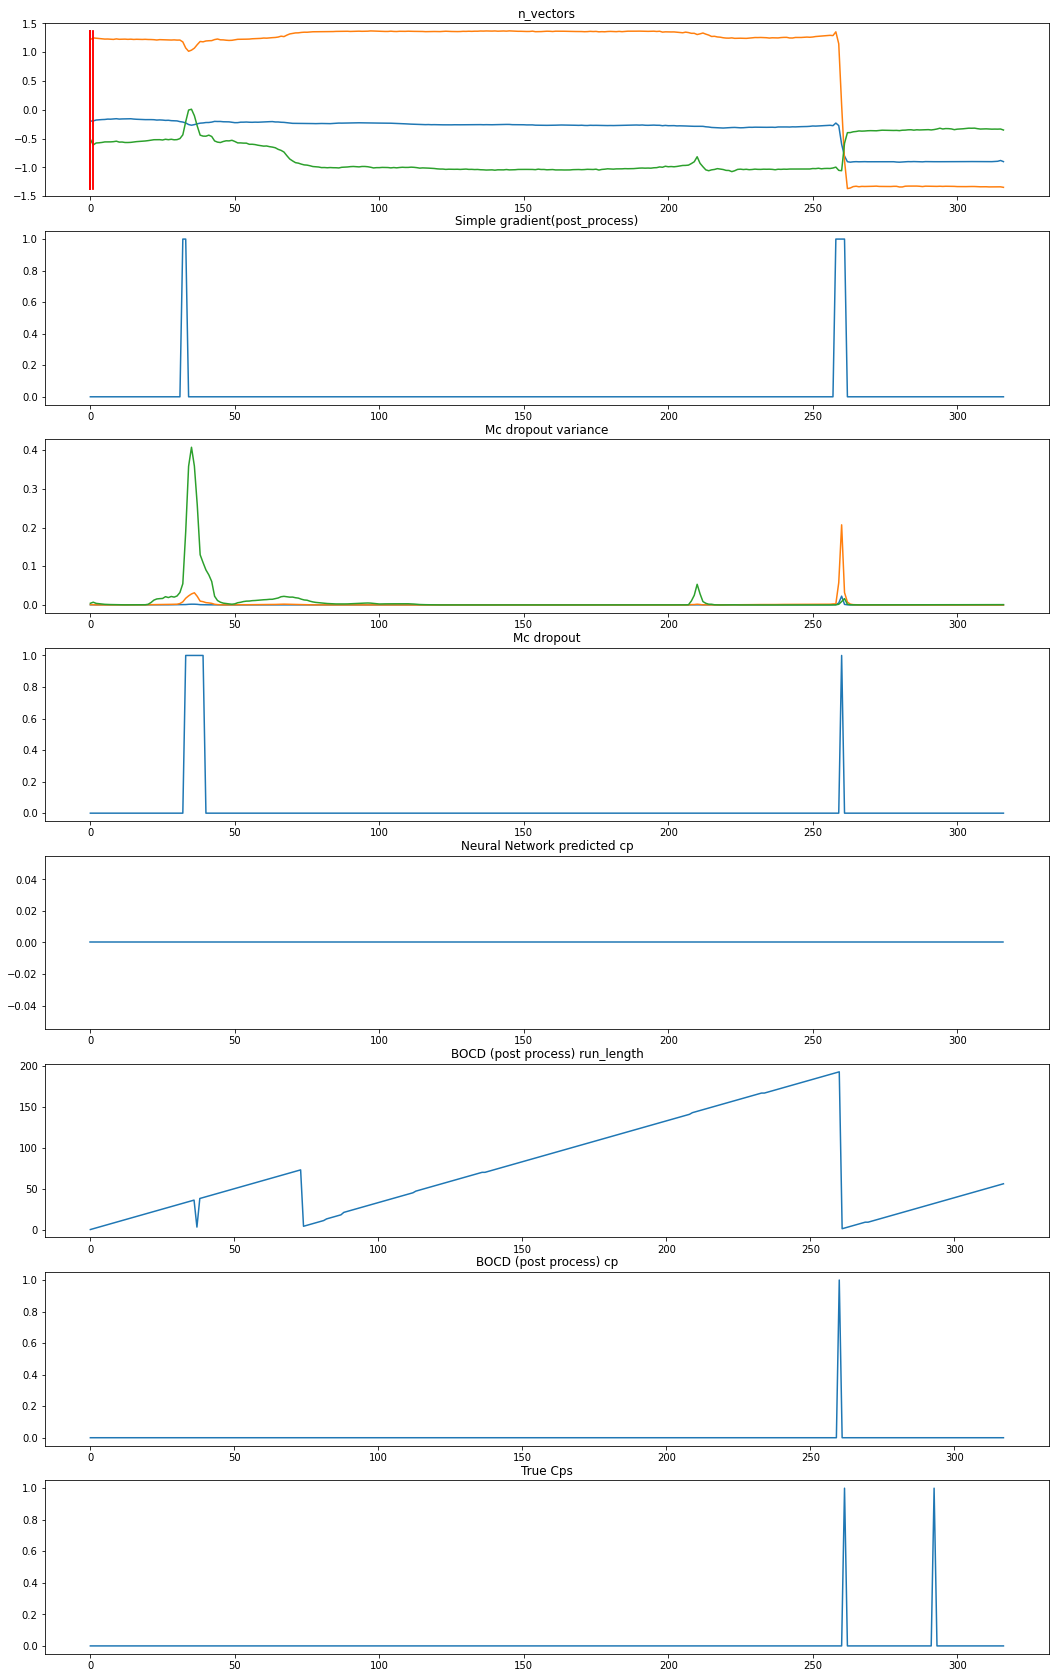

In [119]:
true_cpsSample=true_cps[index,:]
pred_cpsSample={k:v[index,:] for k,v in pred_cps.items()}
y_predSample=results.t_out.coord_main[index,:]
y_varSample=results.t_out.y_var[index,:,:]
bocp_rlSample=bocp_rl[index,:]
plot_changepoints(true_cpsSample, pred_cpsSample, y_predSample, bocp_rlSample, y_varSample)

In [35]:
np.nonzero(pred_cps[cpMethod.neural_network.name])

(array([   0,    0,    0, ..., 3649, 3649, 3649]),
 array([  3,   5,   6, ..., 313, 314, 315]),
 array([0, 0, 0, ..., 0, 0, 0]))

In [36]:
results.t_out.cp_logits[results.t_out.cp_logits>0.5]

array([], dtype=float32)

In [37]:
tmp_cpprob = torch.sigmoid(torch.tensor(results.t_out.cp_logits).float())

In [38]:
torch.min(tmp_cpprob), torch.max(tmp_cpprob), torch.nonzero(tmp_cpprob>0.4)

(tensor(0.0112), tensor(0.5074), tensor([[   0,    3,    0],
         [   0,    5,    0],
         [   0,    6,    0],
         ...,
         [3649,  313,    0],
         [3649,  314,    0],
         [3649,  315,    0]]))

In [66]:
np.nonzero(true_cpsSample), np.nonzero(pred_cps[cpMethod.BOCD.name][index,:])

((array([160, 288, 300]),), (array([155, 289, 301]),))